In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imshow
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import matrix_rank
from PIL import Image 
import warnings
from sklearn.model_selection import train_test_split

# We load datasets:
- "faces" contains a set of 400 images of faces
- "faces_target" contains a person ID for each face

In [2]:
faces = np.load('olivetti_faces.npy')
faces_target = np.load('olivetti_faces_target.npy')

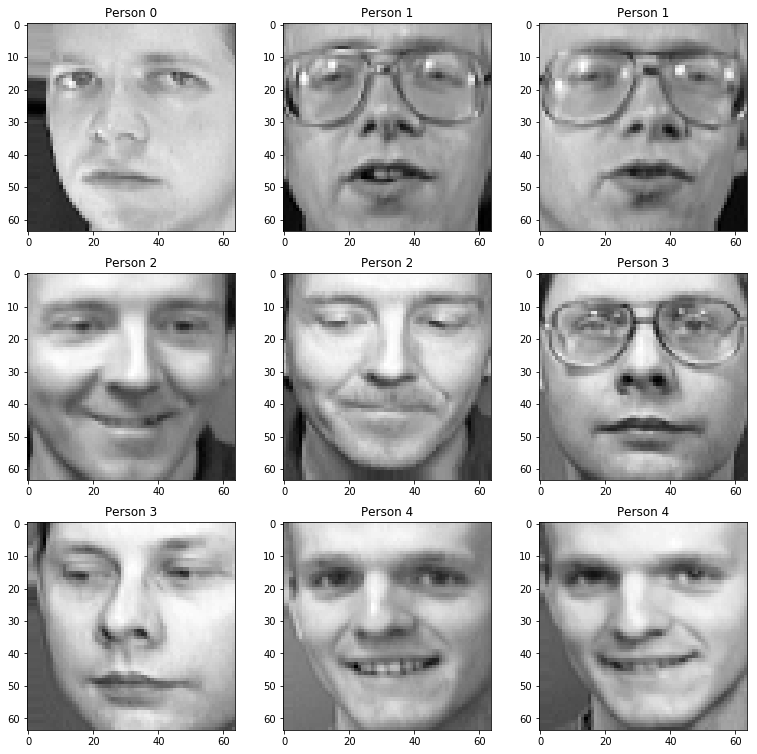

In [3]:
plt.figure(figsize=(13,13))   
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.title("Person "+str(faces_target[5*i]))
    plt.imshow(faces[5*i], cmap='gray')

We must transform each point from (400,64,64) to (400,4096) in order to compute SVD

In [4]:
print("Shape from original input (%d,%d,%d)" % faces.shape )
faces_data = faces.reshape(faces.shape[0], faces.shape[1] * faces.shape[2])
print("Shape after transformation input (%d,%d)" % faces_data.shape )


Shape from original input (400,64,64)
Shape after transformation input (400,4096)


We will take 75% of our dataset to compute the SVD.
Then, we will use the remaining data to make face recognition

In [5]:
n_samples = faces.shape[0]
X = faces_data
n_features = faces.shape[1]
# the label to predict is the id of the person
y = faces_target
n_classes = faces.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
print("Length of Xtrain:",len(Xtrain))
print("Length of ytrain:",len(ytrain))
print("Length of Xtest:",len(Xtest))
print("Length of ytest:",len(ytest))

Total dataset size:
n_samples: 400
n_features: 64
n_classes: 400
Length of Xtrain: 300
Length of ytrain: 300
Length of Xtest: 100
Length of ytest: 100


Once we have our data (Xtrain), we compute the SVD

The most important eigenvectors (eigenfaces)


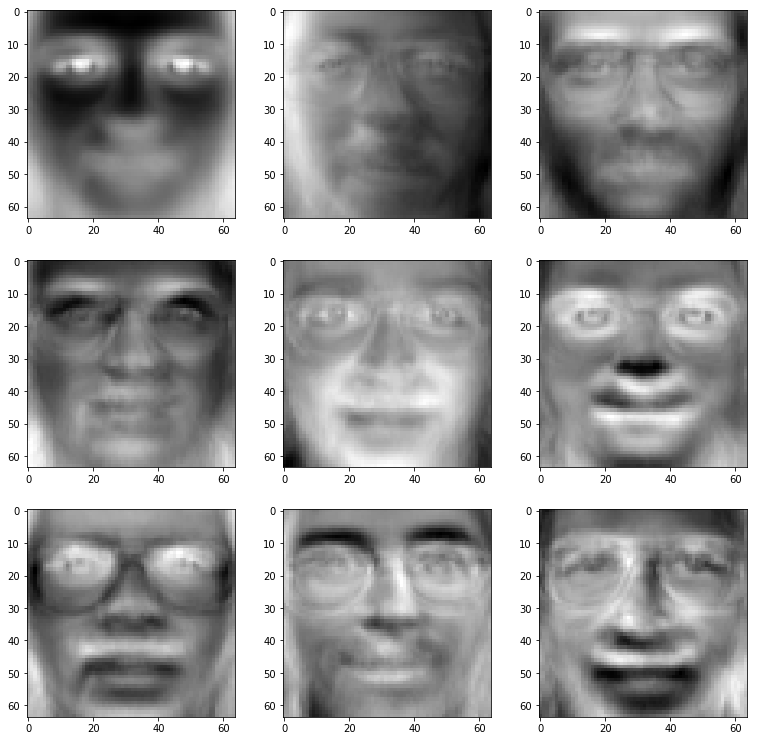

In [6]:
u, s, vt = np.linalg.svd(Xtrain, full_matrices=True)
plt.figure(figsize=(13,13))

print("The most important eigenvectors (eigenfaces)")
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(vt[i-1].reshape(64,64), cmap="gray")

Given the energy plot, we can try using k = 50 reduction to make face recognition

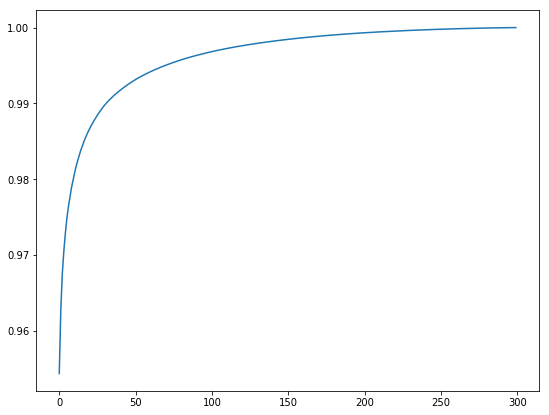

In [7]:
k_energy = []
accum_energy = 0
k = s.size
for i in range(k):
    accum_energy += s[i]**2
    k_energy.append(accum_energy)
plt.figure(figsize=(9,7))
plt.plot(k_energy/accum_energy)

We take the most 50 eigenvector (eigenfaces) and we will store the coordinates in Vt of each point 

In [8]:
most_important_eigenfaces = vt[0:50,:]
coordinates = []

for i in range (Xtrain.shape[0]):
    data_point = Xtrain[i,:]
    coordinates.append(np.dot(most_important_eigenfaces,data_point))
coordinates = np.array(coordinates)


Once we have the coordinates, we can use them to make face recognition. 
Notice that each point of the entry dataset is an array of dimension 50.
If you want to recognise a face, you can obtain the coordinates in vt and
then find the nearest point. (KDTree helps us to find the nearest point)

In [9]:
from scipy import spatial
tree = spatial.KDTree(coordinates)

Now, we iterate over the faces we want to recognise and make our predictions

In [11]:
ypredicted = []  
for i in range (Xtest.shape[0]):
    data_point = Xtest[i,:]
    coordinates_in_vt = np.dot(most_important_eigenfaces,data_point)
    nearest_neighbor_of_data_point = tree.query(coordinates_in_vt)[1]
    ypredicted.append(ytrain[nearest_neighbor_of_data_point])
    print("The face is predicted %d and should be %d" % (ypredicted[i],ytest[i]))

The face is predicted 20 and should be 20
The face is predicted 32 and should be 32
The face is predicted 20 and should be 20
The face is predicted 23 and should be 23
The face is predicted 23 and should be 23
The face is predicted 11 and should be 11
The face is predicted 26 and should be 26
The face is predicted 11 and should be 0
The face is predicted 18 and should be 18
The face is predicted 38 and should be 38
The face is predicted 22 and should be 22
The face is predicted 9 and should be 9
The face is predicted 12 and should be 15
The face is predicted 17 and should be 17
The face is predicted 19 and should be 19
The face is predicted 13 and should be 13
The face is predicted 33 and should be 33
The face is predicted 2 and should be 2
The face is predicted 6 and should be 6
The face is predicted 10 and should be 10
The face is predicted 11 and should be 11
The face is predicted 11 and should be 11
The face is predicted 8 and should be 8
The face is predicted 36 and should be 36
T

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypredicted, normalize=False)

92

For example, the first test image belongs to the following person

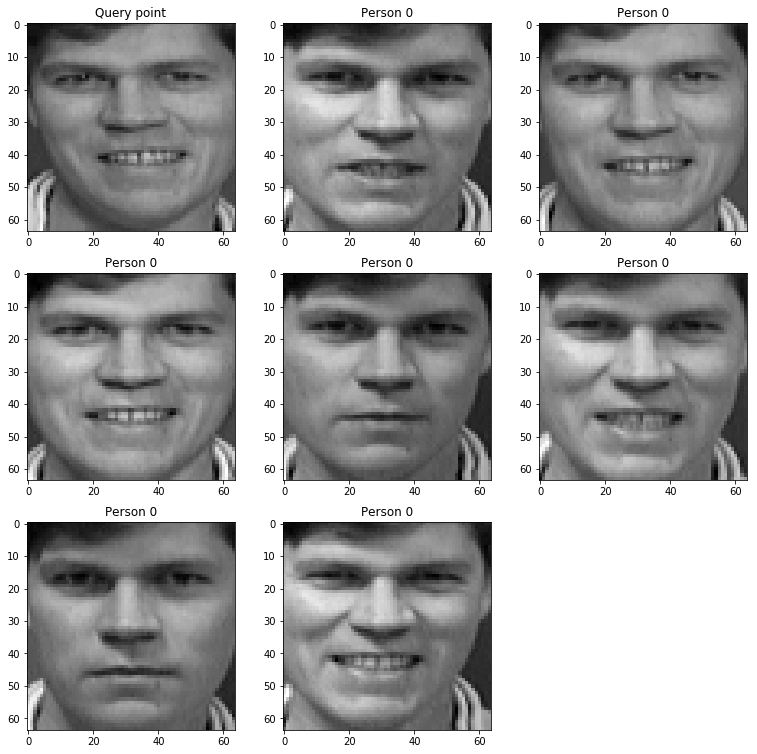

In [37]:
query_person = 1 ## This is the first image that was predicted
predicted_image = ypredicted[query_person] 
indexes = np.argwhere(ytrain == predicted_image)

plt.figure(figsize=(13,13))
for i in range(1,indexes.size):
    plt.subplot(3,3,i+1)
    plt.title("Person "+str(faces_target[i]))
    plt.imshow(Xtrain[indexes[i]].reshape(64,64), cmap='gray')

plt.subplot(3,3,1)
plt.title("Query point")
plt.imshow(Xtest[query_person].reshape(64,64), cmap='gray')